# Starbucks Capstone Challenge

### Introduction
### Business Understanding

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Project Goal

The goal of this project is to get an understanding of users of the Starbucks reward mobile app in order to send effective offers to customers. 

Questions I want to answer with my work are:

- Which users are more likely to respond to an offer?

- Which offers have been effective in the past and what characterizes an effective offer?

- How can we predict the effectivenes of an offer for a certain user?

In [98]:
#importing all necessary libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import fbeta_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
% matplotlib inline

# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data understanding

Let's start by looking at the portfolio dataset. The channels column contains a list of strings that give information through which channels the offer can be distributed. 
It could be useful to convert the column into a dummy variable in the future.

The difficulty column is presumably in dollars and gives information about the minimum amount one has to spend in order to complete the offer.

The duration column gives presumably information about the length of the offer in days. 

There are three different offer types (bogo, discount, informational). This column should also be converted into a dummy variable. In total there are 10 different offers. 

The reward gives information about the reward (presumably amount in dollars) one receives when completing an offer. 

In [99]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [100]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [101]:
# see how many offer types exist
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

Now let's have a look on the profile dataset:

The profile dataset contains information about the user. The first column is the age column. On the first sight I can see some users with age 118 - which I will have to check later on. 

Then, we have information about the date on which the user became a member. Here, we will have to change the type of data later on. 

Furthermore, we have information about gender whcih should be converted into a dummy variable and each user has a unique id. 

The income column has some null values, which should also be checked later on. 

In [102]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [103]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


Last but not least, the transcript dataset:

The event column gives information about the occuring event which can have four different characteristics (transaction, offer received, offer viewed, offer completed). This column also seems to be a candidate for a dummy variable. 

The person is presumably the customer id so that we can join the profile table with the transcript table. 

The time gives information about the time in hours since the start of an offer. 

The value column contains a list of strings which can be for example the offer id, so that we can join the transcript table and portfolio table on that information.

In [104]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [105]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [106]:
# count how often certain events occur
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Data Preparation

As we have seen from the first encounter, we will have to do some data preparation in order to work with the data effectively. 

We start with converting the channels column from the portfolio dataset into dummy variables.
Also I want to convert the offer_type column into dummy variables.

Since we have seen a lot of columns that need to be converted into a dummy variable, I write a function for that purpose.

In [107]:
def dummies_concat(df, column):
    """
    Convert a specific column into a dummy variable and concatenate with the original dataset while dropping the old column. 
    
    Arguments:
        df --> dataframe
        column --> specified column of the dataframe
        
    Output:
        new_df --> new dataframe with dummy variable 
    """
    dummies = pd.get_dummies(df[column])
    new_df = pd.concat([df, dummies], axis = 1)
    new_df = new_df.drop([column], axis = 1)
    return new_df

In [108]:
# the channels row is a bit difficult so the function above cannot be used here
for i, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[i, 'channels']:
            portfolio.loc[i, channel] = 1
        else:
            portfolio.loc[i, channel] = 0
# dropping the old column            
portfolio = portfolio.drop(columns = ['channels'])

In [109]:
portfolio[['web', 'social', 'mobile', 'email']] = portfolio[['web', 'social', 'mobile', 'email']].astype('int')

In [110]:
# make use of the nee function and convert offer_type into dummy
portfolio = dummies_concat(portfolio, 'offer_type')

In [111]:
# check if everything went well
portfolio.head()

,difficulty,duration,id,reward,web,email,social,mobile,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


Now, lets prepare the profile dataset. Its seems like the same amount of null values holds for the gender and income column. Therefore, it is okay to drop all rows. Appararently it seems that for all rows with age = 118 income and gender are all null values. These rows can be dropped.

In [112]:
# count null values in the dataset
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [113]:
# count null values for age = 118
profile[profile['age'] == 118].isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [114]:
# drop all rows with null values
profile = profile.dropna()

In [115]:
# check if there are any null values left
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [116]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


After cleaning the rows, let's have a look at age and income. 

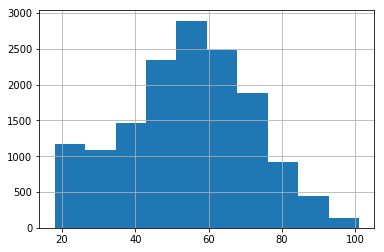

In [117]:
profile['age'].hist()

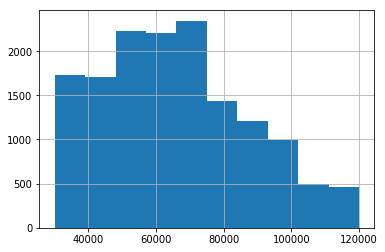

In [118]:
profile['income'].hist()

Also: Have a look at the gender column and convert it into dummy variables. Males are represented more often in the dataset than females. 

Text(0.5,1,'Gender Distribution')

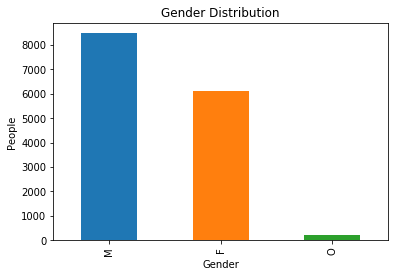

In [119]:
# distribution of the gender variable
gender_counts = profile['gender'].value_counts()
gender_counts.plot(kind='bar')
plt.ylabel('People')
plt.xlabel('Gender')
plt.title('Gender Distribution')

In [120]:
# convert the membership date into a real date column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [121]:
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In the transcript dataset there seems to be no missing values. 
Also, it seems logical that the most common event is the "transaction" event which I think is just a transaction, with or without an offer. The order in which the other events occur are also logical:

offer received > offer viewed > offer completed

Events are going to be converted into dummy variables. 
The value column needs to be converted as well since we definitely need the offer id from the column. 

In [122]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

Text(0.5,1,'Event Distribution')

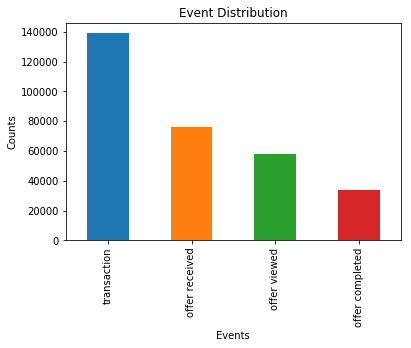

In [123]:
# distribution of events
events_counts = transcript['event'].value_counts()
events_counts.plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('Events')
plt.title('Event Distribution')

In [124]:
# convert event column into dummy variables
transcript = dummies_concat(transcript, 'event')

In [125]:
transcript.head()

,person,time,value,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [126]:
def create_offer_id_column(val):
    """
    Convert a column with dictionary into a list
    
    Arguments:
         val --> Dictionary like information
    Output:
        return value entry of the dictionary for the key
    """
    # return value if key is in the mentioned words. We need to have both versions of offer id to capture all entries. 
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]


In [127]:
def create_amount_column(val):
    """
    Convert a column with dictionary into a list
    
    Arguments:
         val --> Dictionary like information
    Output:
        return value entry of the dictionary for the key
    """
    # return value if key is in the mentioned words
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]
    

In [128]:
# use the above functions to create two new columns with the respective lists
transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
transcript['amount'] = transcript.value.apply(create_amount_column)

In [129]:
transcript.head()

,person,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [130]:
# drop the unnecessary value column
transcript = transcript.drop(['value'], axis = 1)

Now, in the next step I want to combine all three tables accordingly. Therefore, I have to rename some columns. 

In [131]:
# rename id in order to join on offer ids
portfolio = portfolio.rename(columns = {'id': 'offer_id'})
# rename id in order to join customer ids
profile = profile.rename(columns = {'id': 'person'})


In [132]:
transcript.head()

,person,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [133]:
portfolio.head()

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [134]:
# first merge transcript dataset with profile dataset
transcript_profile = pd.merge(transcript, profile, on = 'person')

In [135]:
transcript_profile.shape

(272762, 12)

In [136]:
# then merge the newly created dataset with portfolio dataset
portfolio_merge = pd.merge(transcript_profile, portfolio, on = 'offer_id', how = 'left')

In [137]:
portfolio_merge.shape

(272762, 22)

In [138]:
final_df = portfolio_merge

# Implementation

Before implementing a machine learning model, I want to have a look on the data and see what we can retreive from the information so far. 

Questions I want to answer:

Which offer type is completed most often?

Which gender completes offers more often?

Do income and age have an influence on the effectiveness of the offer?

In [139]:
# Let us have a look on the transaction column. I know that we cannot link transaction with any offer id but maybe there is something special about the persons that transact. 
final_df[final_df['transaction'] == 1].describe()

,time,offer completed,offer received,offer viewed,transaction,amount,age,income,difficulty,duration,reward,web,email,social,mobile,bogo,discount,informational
count,123957.000000,123957.0,123957.0,123957.0,123957.0,123957.000000,123957.000000,123957.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,381.278201,0.0,0.0,0.0,1.0,13.996325,52.713965,61843.510250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,201.829085,0.0,0.0,0.0,0.0,31.749420,17.906667,20661.890394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.0,0.0,0.0,1.0,0.050000,18.000000,30000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,210.000000,0.0,0.0,0.0,1.0,3.660000,39.000000,46000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,402.000000,0.0,0.0,0.0,1.0,10.800000,54.000000,60000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,552.000000,0.0,0.0,0.0,1.0,19.130000,65.000000,74000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,714.000000,0.0,0.0,0.0,1.0,1062.280000,101.000000,120000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
final_df.describe()

,time,offer completed,offer received,offer viewed,transaction,amount,age,income,difficulty,duration,reward,web,email,social,mobile,bogo,discount,informational
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,123957.000000,272762.000000,272762.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000
mean,366.707694,0.118946,0.243806,0.182797,0.454451,13.996325,53.840696,64337.000755,7.890561,6.625207,4.442445,0.806747,1.0,0.658311,0.917160,0.428978,0.418743,0.152280
std,200.359087,0.323726,0.429378,0.386500,0.497922,31.749420,17.551337,21243.762941,5.041335,2.133035,3.372362,0.394851,0.0,0.474277,0.275641,0.494932,0.493355,0.359293
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,18.000000,30000.000000,0.000000,3.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,0.000000,0.000000,0.000000,0.000000,3.660000,41.000000,48000.000000,5.000000,5.000000,2.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000
50%,408.000000,0.000000,0.000000,0.000000,0.000000,10.800000,55.000000,62000.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
75%,528.000000,0.000000,0.000000,0.000000,1.000000,19.130000,66.000000,78000.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
max,714.000000,1.000000,1.000000,1.000000,1.000000,1062.280000,101.000000,120000.000000,20.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


As this seems not to be the case we can drop the column from the final dataframe


In [141]:
# drop the transaction column
final_df = final_df.drop(['transaction'], axis = 1)

Furthermore, I want to get an idea about the ratio of completed offers in order to compare feature results with this baseline. 

In [142]:
completed_offers = final_df['offer completed'].value_counts()[1]
received_offers = final_df['offer received'].value_counts()[1]
viewed_offers = final_df['offer viewed'].value_counts()[1]

In [143]:
print("The number of completed offers is: {}".format(completed_offers))
print("The number of received offers is: {}".format(received_offers))
print("The number of viewed offers is: {}".format(viewed_offers))
print("Therefore the ratio of offers received to viewed is: {0:.2f}%".format((viewed_offers/received_offers)*100))
print("Therefore the ratio of offers viewed to completed is: {0:.2f}%".format((completed_offers/viewed_offers)*100))
print("Therefore the ratio of offers received to completed is: {0:.2f}%".format((completed_offers/received_offers)*100))

The number of completed offers is: 32444
The number of received offers is: 66501
The number of viewed offers is: 49860
Therefore the ratio of offers received to viewed is: 74.98%
Therefore the ratio of offers viewed to completed is: 65.07%
Therefore the ratio of offers received to completed is: 48.79%


With this baseline the ratio of completed offers can be compared to the offer types.
The discount offer type has a higher ratio of received to completed offers.

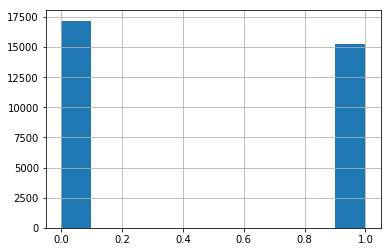

In [144]:
# Distribution of bogo offer type for completed offers
final_df[final_df['offer completed'] == 1].bogo.hist()

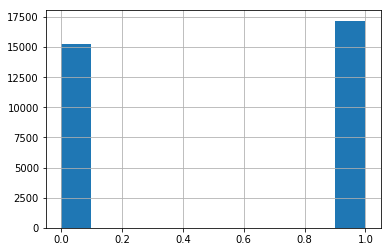

In [145]:
# distribution of discount offer type for completed offers 
final_df[final_df['offer completed'] == 1].discount.hist()

In [146]:
# metrics for bogo offer type
bogo_received = final_df[final_df['offer received'] == 1].bogo.value_counts()[1]
bogo_viewed = final_df[final_df['offer viewed'] == 1].bogo.value_counts()[1]
bogo_completed = final_df[final_df['offer completed'] == 1].bogo.value_counts()[1]
print("The number of completed offers is: {}".format(bogo_completed))
print("The number of received offers is: {}".format(bogo_received))
print("The number of viewed offers is: {}".format(bogo_viewed))
print("Therefore the ratio of offers received to viewed is: {0:.2f}%".format((bogo_viewed/bogo_received)*100))
print("Therefore the ratio of offers viewed to completed is: {0:.2f}%".format((bogo_completed/bogo_viewed)*100))
print("Therefore the ratio of offers received to completed is: {0:.2f}%".format((bogo_completed/bogo_received)*100))

The number of completed offers is: 15258
The number of received offers is: 26537
The number of viewed offers is: 22039
Therefore the ratio of offers received to viewed is: 83.05%
Therefore the ratio of offers viewed to completed is: 69.23%
Therefore the ratio of offers received to completed is: 57.50%


In [147]:
# metrics for disocunt offer type
discount_received = final_df[final_df['offer received'] == 1].discount.value_counts()[1]
discount_viewed = final_df[final_df['offer viewed'] == 1].discount.value_counts()[1]
discount_completed = final_df[final_df['offer completed'] == 1].discount.value_counts()[1]
print("The number of completed offers is: {}".format(discount_completed))
print("The number of received offers is: {}".format(discount_received))
print("The number of viewed offers is: {}".format(discount_viewed))
print("Therefore the ratio of offers received to viewed is: {0:.2f}%".format((discount_viewed/discount_received)*100))
print("Therefore the ratio of offers viewed to completed is: {0:.2f}%".format((discount_completed/discount_viewed)*100))
print("Therefore the ratio of offers received to completed is: {0:.2f}%".format((discount_completed/discount_received)*100))

The number of completed offers is: 17186
The number of received offers is: 26664
The number of viewed offers is: 18461
Therefore the ratio of offers received to viewed is: 69.24%
Therefore the ratio of offers viewed to completed is: 93.09%
Therefore the ratio of offers received to completed is: 64.45%


In [148]:
# metrics for informational offer type
# there are no complted offers for this type
informational_received = final_df[final_df['offer received'] == 1].informational.value_counts()[1]
informational_viewed = final_df[final_df['offer viewed'] == 1].informational.value_counts()[1]
informational_received = final_df[final_df['offer received'] == 1].informational.value_counts()[1]
informational_viewed = final_df[final_df['offer viewed'] == 1].informational.value_counts()[1]
print("The number of received offers is: {}".format(informational_received))
print("The number of viewed offers is: {}".format(informational_viewed))
print("Therefore the ratio of offers received to viewed is: {0:.2f}%".format((informational_viewed/informational_received)*100))

The number of received offers is: 13300
The number of viewed offers is: 9360
Therefore the ratio of offers received to viewed is: 70.38%


It seems that the proportion of women is higher when we just look at completed offers. It might be more effective to send offers to women. 


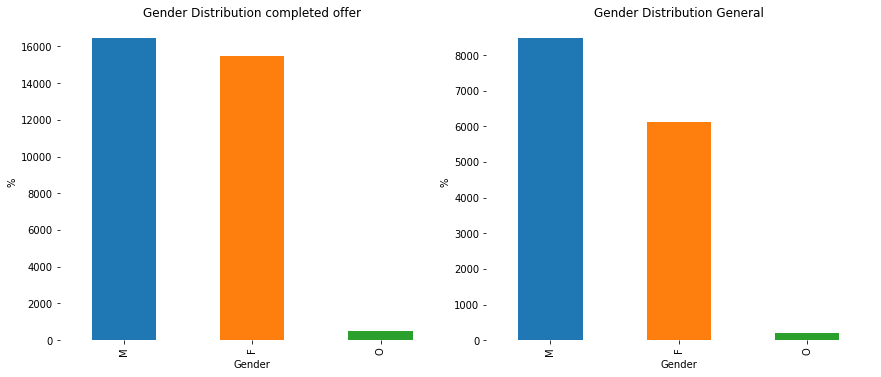

In [149]:
# Which gender completes offers more often?

fig,ax= plt.subplots(1,2,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()
# gender with completed offers
final_df[final_df['offer completed'] == 1].gender.value_counts().plot.bar(ax=ax[0])
ax[0].set_title("Gender Distribution completed offer")
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("%", fontsize=10)
sns.despine(bottom=True, left=True)

#gender in general
profile.gender.value_counts().plot.bar(ax=ax[1])
ax[1].set_title("Gender Distribution General")
ax[1].set_xlabel("Gender", fontsize=10)
ax[1].set_ylabel("%", fontsize=10)
sns.despine(bottom=True, left=True)

The next question is at which age are people more likely to complete an offer? Therefore, I look at the distribution for the gender distribution in general and for completed offers only. 
At first sight, the distribution looks very much the same. 

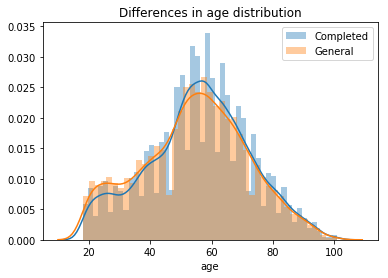

In [150]:

# age with completed offers
sns.distplot(final_df[final_df['offer completed'] == 1].age, label = 'Completed')

#gender in general
sns.distplot(profile.age, label = 'General')

plt.legend(prop={'size': 10})
plt.title('Differences in age distribution')
plt.figure(figsize=(50,50))

The same bothers me for the income column. Thus, I plot both distributions together. Here, the difference in distribution seems more visible. 

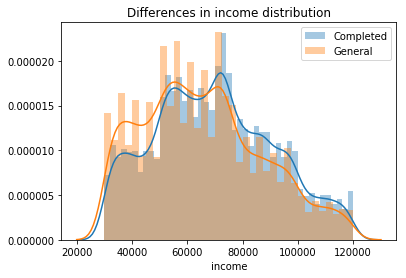

In [151]:
# income with completed offers
sns.distplot(final_df[final_df['offer completed'] == 1].income, label = 'Completed')

#gender in general
sns.distplot(profile.income, label = 'General')

plt.legend(prop={'size': 10})
plt.title('Differences in income distribution')
plt.figure(figsize=(50,50))

Also, I want to get a feeling for the most completed offers. What is their type and what are the characteristics?

In [152]:
# count the number of how often a specific offer was completed
final_df[final_df['offer completed'] == 1].offer_id.value_counts()

fafdcd668e3743c1bb461111dcafc2a4    5003
2298d6c36e964ae4a3e7e9706d1fb8c2    4886
9b98b8c7a33c4b65b9aebfe6a799e6d9    4188
f19421c1d4aa40978ebb69ca19b0e20d    4103
2906b810c7d4411798c6938adc9daaa5    3911
ae264e3637204a6fb9bb56bc8210ddfd    3657
0b1e1539f2cc45b7b9fa7c272da2e1d7    3386
4d5c57ea9a6940dd891ad53e9dbe8da0    3310
Name: offer_id, dtype: int64

The offer id most often completed is a disocunt offer type which is distributed through all available channels with difficulty and duration of 10. The reward is 2. Also, it takes on average 356 hours to complete the offer. 

In [153]:
# have a look at one of the above offer ids
final_df[final_df['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4'].head(1)

,person,time,offer completed,offer received,offer viewed,offer_id,amount,age,became_member_on,gender,...,difficulty,duration,reward,web,email,social,mobile,bogo,discount,informational
25,e2127556f4f64592b11af22de27a7932,504,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,68,2018-04-26,M,...,10.0,10.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [154]:
# mean time it takes to complete the offer
final_df[final_df['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4'].time.mean()


355.58520651090686

Another often completed offer is also type disocunt and distributed through all channels while having a difficutly of 7 and duration of 7 with a reward of 3. The average time of completion is slighly higher with 360. 

In [155]:
final_df[final_df['offer_id'] == '2298d6c36e964ae4a3e7e9706d1fb8c2'].head(1)

,person,time,offer completed,offer received,offer viewed,offer_id,amount,age,became_member_on,gender,...,difficulty,duration,reward,web,email,social,mobile,bogo,discount,informational
51,2eeac8d8feae4a8cad5a6af0499a211d,168,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,58,2017-11-11,M,...,7.0,7.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [156]:
# mean time it takes to complete the offer
final_df[final_df['offer_id'] == '2298d6c36e964ae4a3e7e9706d1fb8c2'].time.mean()


359.67656249999999

The third offer id in our result list is of type bogo and not distributed through the social channel. It has a difficulty of 5, duration of 7 and reward of 5. Again, the time of completion is on average a little bit higher with 362. 

It seems that the higher the reward, the longer it takes for completion. Still, this could also have to do with the offer type. 

In [157]:
final_df[final_df['offer_id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9'].head(1)

,person,time,offer completed,offer received,offer viewed,offer_id,amount,age,became_member_on,gender,...,difficulty,duration,reward,web,email,social,mobile,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,...,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [158]:
# mean time it takes to complete the offer
final_df[final_df['offer_id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9'].time.mean()


362.30072362927916

Now, that I had a look at the data myself, I have already some ideas in mind. 

Furthermore, I want to implement a machine learning model. 

In order to implment such a model, I want to focus on the variable "offer completed" as the target variable. Therefore, I am dropping irrelevant features right now. Also, I will drop rows with nan values:

- offer viewed and offer received will be dropped since that is not what I am interested in
- the amount column is also dropped since I cannot join it with offer ids 
- the gender column has to be converted into dummy variables in order to work properly with the algorithm
- the email colum is also dropped since it only has values for '1' and will not add useful information to the model

Also I will have to scale all numercial features. 

In [159]:
# drop three columns
offers_model = final_df.drop(['offer viewed','offer received', 'amount'], axis = 1)

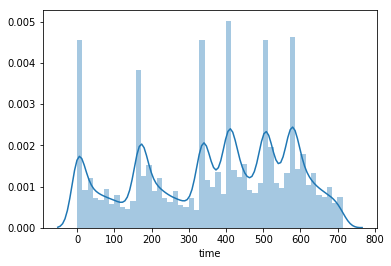

In [160]:
# have a look on the distribution of the time column
sns.distplot(offers_model.time)

In [161]:
# convert gender into dummy variables
offers_model = dummies_concat(offers_model, 'gender')

In [162]:
offers_model.head()

,person,time,offer completed,offer_id,age,became_member_on,income,difficulty,duration,reward,web,email,social,mobile,bogo,discount,informational,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,100000.0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,100000.0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,None,75,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,100000.0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,None,75,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


In [163]:
# look at the values of email column
offers_model['email'].value_counts()

1.0    148805
Name: email, dtype: int64

In [164]:
# drop rows with null values in the offer id column
offers_model = offers_model[offers_model['offer_id'].notnull()]
# drop the email column
offers_model = offers_model.drop(['email'], axis = 1)


The first round of cleaning is done. Still, some columns will not give useful information for the algorithm. 

- the person or customer id can be droped which is also very important for data security
- became_member_on also is not relevant for me at the moment so it is also dropped
- the offer id can also be dropped because we have all relevant information on the offer still in other columns
- the informational column is also dropped because I know that no offer type is completed 

In [165]:
offers_model = offers_model.drop(['person', 'became_member_on', 'offer_id', 'informational'], axis=1)

In [166]:
offers_model.head()

,time,offer completed,age,income,difficulty,duration,reward,web,social,mobile,bogo,discount,F,M,O
0,0,0,75,100000.0,5.0,7.0,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
1,6,0,75,100000.0,5.0,7.0,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
3,132,1,75,100000.0,5.0,7.0,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
5,168,0,75,100000.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0
6,216,0,75,100000.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0


Now, the next process is to scale numerical features between 0 and 1. I am doing it with the help of the MinMax Scaler

In [167]:
# scale all numerical features besides time
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

# identify all columns that need to be scaled.
numericals = offers_model.columns[2:6]

features_log_minmax_transform = pd.DataFrame(data = offers_model)
features_log_minmax_transform[numericals] = scaler.fit_transform(offers_model[numericals])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,time,offer completed,age,income,difficulty,duration,reward,web,social,mobile,bogo,discount,F,M,O
0,0,0,0.686747,0.777778,0.25,0.571429,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
1,6,0,0.686747,0.777778,0.25,0.571429,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
3,132,1,0.686747,0.777778,0.25,0.571429,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
5,168,0,0.686747,0.777778,0.00,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0
6,216,0,0.686747,0.777778,0.00,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0


In [168]:
# scale the time column
offers_model['time'] = scaler.fit_transform(offers_model['time'].values.reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [169]:
offers_model.head()

,time,offer completed,age,income,difficulty,duration,reward,web,social,mobile,bogo,discount,F,M,O
0,0.000000,0,0.686747,0.777778,0.25,0.571429,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
1,0.008403,0,0.686747,0.777778,0.25,0.571429,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
3,0.184874,1,0.686747,0.777778,0.25,0.571429,5.0,1.0,0.0,1.0,1.0,0.0,1,0,0
5,0.235294,0,0.686747,0.777778,0.00,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0
6,0.302521,0,0.686747,0.777778,0.00,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0


In [170]:
# convert dummy variables into another data type
offers_model[['web', 'social', 'mobile', 'bogo', 'discount']] = offers_model[['web', 'social', 'mobile', 'bogo', 'discount']].astype(int)

In [171]:
offers_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 272761
Data columns (total 15 columns):
time               148805 non-null float64
offer completed    148805 non-null uint8
age                148805 non-null float64
income             148805 non-null float64
difficulty         148805 non-null float64
duration           148805 non-null float64
reward             148805 non-null float64
web                148805 non-null int64
social             148805 non-null int64
mobile             148805 non-null int64
bogo               148805 non-null int64
discount           148805 non-null int64
F                  148805 non-null uint8
M                  148805 non-null uint8
O                  148805 non-null uint8
dtypes: float64(6), int64(5), uint8(4)
memory usage: 14.2 MB


In [172]:
offers_model.head()

,time,offer completed,age,income,difficulty,duration,reward,web,social,mobile,bogo,discount,F,M,O
0,0.000000,0,0.686747,0.777778,0.25,0.571429,5.0,1,0,1,1,0,1,0,0
1,0.008403,0,0.686747,0.777778,0.25,0.571429,5.0,1,0,1,1,0,1,0,0
3,0.184874,1,0.686747,0.777778,0.25,0.571429,5.0,1,0,1,1,0,1,0,0
5,0.235294,0,0.686747,0.777778,0.00,0.000000,0.0,0,1,1,0,0,1,0,0
6,0.302521,0,0.686747,0.777778,0.00,0.000000,0.0,0,1,1,0,0,1,0,0


Now, it is time to prepare the data for the model. First, I am defining X and Y and have a glance at the correlation matrix. 

In [173]:
# define the X dataset
X = offers_model.drop(['offer completed'], axis=1)
# define the target variable
Y = offers_model['offer completed']

Correlation among numeric variables: 

time               0.119941
offer completed    1.000000
age                0.032165
income             0.074100
difficulty         0.149105
duration           0.171684
reward             0.079198
web                0.107701
social            -0.013701
mobile            -0.041234
bogo               0.044073
discount           0.118771
F                  0.052111
M                 -0.052681
O                  0.003178
Name: offer completed, dtype: float64 

Present the result in heatmap: 


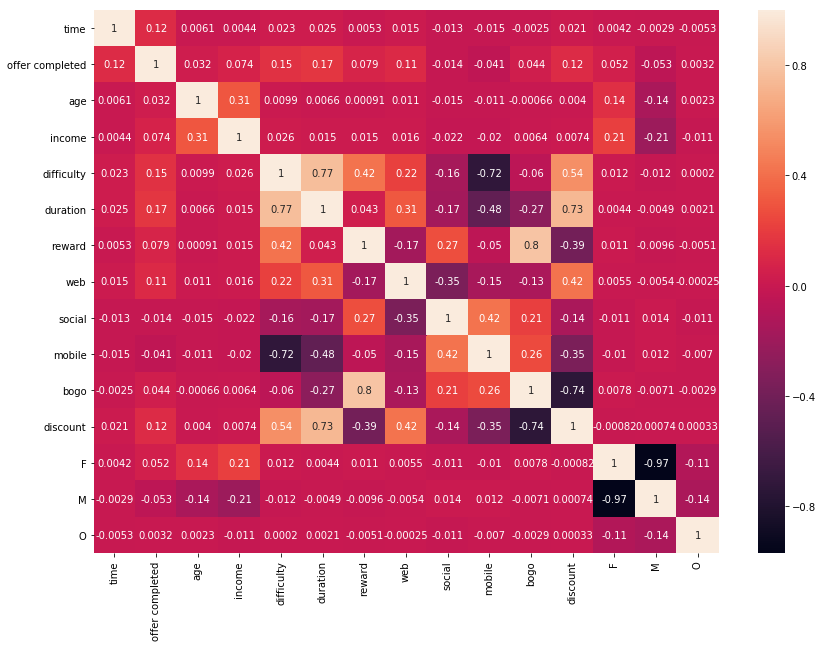

In [174]:
# have a look at the correlation between the features
print('Correlation among numeric variables: \n')

plt.figure(figsize=(14,10))
corr = offers_model.corr()
print(corr['offer completed'], '\n')

print('Present the result in heatmap: ')
sns.heatmap(corr, annot=True)
plt.show()

In [175]:
# split the dataset into test and training set with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [176]:
# have a look at the shape of datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((119044, 14), (29761, 14), (119044,), (29761,))

The plan is to implement a RandomForest Classifier and tune feature selection with GridSearch. Therefore, I am writing a function. 

In [177]:
def build_model_gs():
    """
    Build a machine learning pipeline with gridsearch
    Output:
    A machine learning pipeline with gridsearch
    """

    #define the classifier for usage
    clf = RandomForestClassifier()

    # define the parameters the gridsearch has to search
    parameters_grid = {

        'n_estimators': [10,20,50,100],
        'min_samples_split': [10, 20],
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt'],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [2, 10,15, 20],
    }
    
    # define the gridearch classifier with classifier and parameters
    cv = GridSearchCV(estimator = clf, param_grid=parameters_grid)

    # return the model
    return cv

I also want to be able to evaluate the performance of my model, so I also implement a function for that.

In [178]:
def evaluate_model(model, X_test, Y_test):
    """
    This function evaluates a machine learning model in
    terms of performance
    Arguments:
        model -> Machine learning model
        X_test --> Test data for features
        Y_test --> Test data for labels
        category_names --> category names
    Output:
        performance metrics -> Performance of the
        machine learning model
    """
    # predict y values for the test set
    y_prediction_test = model.predict(X_test)

    # calculate and print the accuracy of the model
    accuracy = (y_prediction_test == y_test).mean().mean()
    print('The accuracy of the model is {0:.2f}%'.format(accuracy*100))

    #print the classification report
    y_pred = pd.DataFrame(y_prediction_test)

    print(classification_report(y_test, y_pred))

Now, let's try the model. 

In [179]:
print('Building model...')
model = build_model_gs()

print('Training model...')
model.fit(X_train, y_train)

print('Evaluating model...')
evaluate_model(model, X_test, y_test)

Building model...
Training model...
Evaluating model...
The accuracy of the model is 80.10%
             precision    recall  f1-score   support

          0       0.82      0.96      0.88     23276
          1       0.62      0.22      0.33      6485

avg / total       0.77      0.80      0.76     29761



The model gives us its chosen best paramters. After viewing them, I am going to fit the model on training data again and afterwards evaluate it again. 

In [186]:
# print the parameters gridsearch has decided are the best
print('Best parameter:')
model.best_params_

Best parameter:


{'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 10}

In [187]:
# have a look at the model and the parameters set
model

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100], 'min_samples_split': [2, 10, 20], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [2, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [188]:
#Initialize the model with best parameters
model_optimized = RandomForestClassifier(criterion = 'gini', max_features= 'sqrt',min_samples_split= 2,n_estimators=10,min_samples_leaf=15)


In [189]:
# fit und evaluate the optimized model
print('Training model...')
model_optimized.fit(X_train, y_train)

print('Evaluating model...')
evaluate_model(model_optimized, X_test, y_test)

Training model...
Evaluating model...
The accuracy of the model is 79.83%
             precision    recall  f1-score   support

          0       0.81      0.96      0.88     23276
          1       0.61      0.21      0.31      6485

avg / total       0.77      0.80      0.76     29761



The last thing I want to know is the feature importance of the model. Therefore, I am going to create a graph.

In [190]:
# have a look at the feature importances
model_optimized.feature_importances_

array([  6.12841569e-01,   8.35626644e-02,   9.93654022e-02,
         7.94189407e-02,   3.13030687e-02,   2.49644408e-02,
         1.07054412e-02,   4.66092740e-03,   9.93859511e-04,
         2.06047869e-02,   2.08637562e-02,   5.35999099e-03,
         4.88381690e-03,   4.71334815e-04])

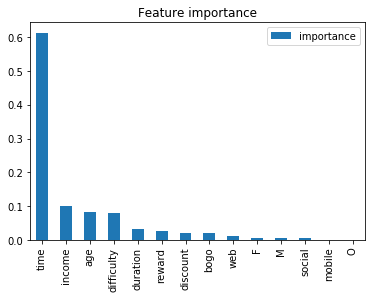

In [191]:
#create a dataframe and graph for feature importance
feature_importances = pd.DataFrame(model_optimized.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Feature importance')
plt.show()

### Conclusion

I now have implemented a RandomForest Classifier that can help Starbucks send certain offer types to the right customers. 

Overall, I think this was a great challenge to look at a real world example. Some of the data columns were somewhat confusing since the datatype and some specific column description were not given in every case. Still, the datasets are understandable and the amount of data is aslo handable. 

The goal of my work was to answer these questions:

Which users are more likely to respond to an offer?

Which offers have been effective in the past and what characterizes an effective offer?

How can we predict the effectivenes of an offer for a certain user?

## Which users are more likely to respond to an offer?

It seems that female customers have a tendency to respond to offers more often than males. Therefore, a gender driven offer design should certainly be followed by Starbucks. From the data I can retrieve that age and income have a sort of influence on offer completion. 

## Which offers have been effective in the past and what characterizes an effective offer?

This question can be answered even without the classifier. Effective offers of the past have been of type disocunt and bogo (discount being more effective than bogo). Offers with type discount have a 64% chance of being comlpeted when a customers receives such an offer. For bogo this is true for "only" 57% of customers. Nonetheless, this is just the ratio from received to completed. Dependent on what Starbucks aims for the ratio of received to viewed or viewed to completed might also be of special interest in the future.

Also, the offer type most often completed has a duration and difficulty of 10 with a reward of 2. 

## How can we predict the effectivenes of an offer for a certain user?

The main drivers the RandomForest Classifier gives us for offer completion are: time, income, age, duration and reward. All other features have a smaller impact on the outcome. 



## Improvements

Since the offer type "informational" was not completed at all in my dataset, I have dropped it from the final table. Still, it could be of useful information to look at the content of such offers and how they effect customers in a certain way. This could be negative or positive.

This corresponds to the point that it was at first hard to define what a "positive" response to an offer means. It could also be that viewing an offer after receiving it but still not comleting it can have a positive impact on the customer retention in the future. For this project I decided to take offer completion as the positive outcome. 

Additionally, it was hard to look at the problem where people get offers but never view them and still spend enough money on the platform. This is also something, I would have a look on in the future. For this purpose it would be good to have dataset only for this kind of customers. 

Also, I dropped some columns from the dataset that could have been important for the machine learning model as well (e.g. became_member_on). One could include columns like that in the feature to tune the model and get more accurate results.

I decided to use a RandomForest Classifier for this purpose. Of course, I could have also compared the performance of my tuned model to that of others. This could be of relevance in the future as well.


## Future research

Questions I am asking myself for the future:

- has viewing an offer but not comleting it right now an impact on customer retention?
- how many offers completes a customer in one month/year/quarter?
- is there a way to have some kind of A/B testing fo different offer types in terms of difficulty/reward etc.?
- which type of machine learning model is useful for this problem?